# cost functions comparison: exercise 12.4

## Exercise 12.4

Starting from samples of pseudo-random numbers generated 
according to a Gaussian probability density function,
using the technique of the toy experiments
study the distribution of the minimum of the cost function
used by `iminuit` in Gaussian fits.
  * Does it match a $\chi^2$ distribution for any number of events,
    for the cases of maximum likelihood, extended maximum likelihood, and least squares?

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from myrand import generate_TCL_ms
from iminuit import Minuit
from scipy.stats import norm
from math import floor, ceil, sqrt

# for the binning choice
def sturges (N) :
    return floor (1 + 3.322 * np.log (N))

# parameters valid for all tests
N_toys = 5000
sample_size = 500    
bins = sturges (sample_size)

### binned likelihood

In [2]:
from iminuit.cost import BinnedNLL

def mod_signal_bin_LL (bin_edges, mu, sigma) :
    ''' fitting model for binned likelihood'''
    return norm.cdf (bin_edges, mu, sigma)
        
means_bin_LL = []
sigmas_bin_LL = []
Q2_bin_LL = []
N_dof_LL = 0

for iToy in range (N_toys) :
    subsample = generate_TCL_ms (1., 0.7, sample_size)
    bin_content, bin_edges = np.histogram (subsample, bins, 
                                           range = (floor (min (subsample)), ceil (max (subsample))))

    my_cost_func_bin_LL = BinnedNLL (bin_content, bin_edges, mod_signal_bin_LL)
    my_minuit_bin_LL = Minuit (
                            my_cost_func_bin_LL, 
                            mu = np.mean (subsample), 
                            sigma = np.std (subsample),
                           )
    my_minuit_bin_LL.limits['sigma'] = (0, None)
    my_minuit_bin_LL.migrad ()
    if not my_minuit_bin_LL.valid : continue
    means_bin_LL.append (my_minuit_bin_LL.values['mu'])
    sigmas_bin_LL.append (my_minuit_bin_LL.values['sigma'])
    Q2_bin_LL.append (my_minuit_bin_LL.fval)
    if (iToy == 0) : N_dof_LL = my_minuit_bin_LL.ndof

### extended binned likelihood

In [3]:
from iminuit.cost import ExtendedBinnedNLL

def mod_signal_bin_ext_LL (bin_edges, N_signal, mu, sigma) :
    ''' fitting model for extended binned likelihood'''
    return N_signal * norm.cdf (bin_edges, mu, sigma)
        
means_bin_ext_LL = []
sigmas_bin_ext_LL = []
Q2_bin_ext_LL = []
N_dof_ext_LL = 0

for iToy in range (N_toys) :
    subsample = generate_TCL_ms (1., 0.7, sample_size)
    bin_content, bin_edges = np.histogram (subsample, bins, 
                                           range = (floor (min (subsample)), ceil (max (subsample))))

    my_cost_func_bin_ext_LL = ExtendedBinnedNLL (bin_content, bin_edges, mod_signal_bin_ext_LL)
    my_minuit_bin_ext_LL = Minuit (
                            my_cost_func_bin_ext_LL, 
                            N_signal = len (subsample),
                            mu = np.mean (subsample), 
                            sigma = np.std (subsample),
                           )
    my_minuit_bin_ext_LL.limits['N_signal', 'sigma'] = (0, None)
    my_minuit_bin_ext_LL.migrad ()
    if not my_minuit_bin_ext_LL.valid : continue
    means_bin_ext_LL.append (my_minuit_bin_ext_LL.values['mu'])
    sigmas_bin_ext_LL.append (my_minuit_bin_ext_LL.values['sigma'])
    Q2_bin_ext_LL.append (my_minuit_bin_ext_LL.fval)
    if (iToy == 0) : N_dof_ext_LL = my_minuit_bin_ext_LL.ndof


### least squares

In [4]:
from iminuit.cost import LeastSquares

def func_approx (x, N_events, mean, sigma, bin_width) :
    return N_events * norm.pdf (x, mean, sigma) * bin_width

means_LS = []
sigmas_LS = []
Q2_bin_LS = []
N_dof_LS = 0

for iToy in range (N_toys) :
    subsample = generate_TCL_ms (1., 0.7, sample_size)
    bin_content, bin_edges = np.histogram (subsample, bins, 
                                           range = (floor (min (subsample)), ceil (max (subsample))))
    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    sigma_y = [max (sqrt (num), 1.) for num in bin_content]

    least_squares = LeastSquares (bin_centres, bin_content, sigma_y, func_approx)
    my_minuit_LS = Minuit (least_squares,
                           N_events = sample_size,
                           mean = np.mean (subsample), 
                           sigma = np.std (subsample),
                           bin_width = bin_centres[1] - bin_centres[0]
                          )
    my_minuit_LS.fixed["bin_width", "N_events"] = True
    my_minuit_LS.migrad ()
    my_minuit_LS.hesse ()
    if not my_minuit_LS.valid : continue
    means_LS.append (my_minuit_LS.values['mean'])
    sigmas_LS.append (my_minuit_LS.values['sigma'])
    Q2_bin_LS.append (my_minuit_LS.fval)
    if (iToy == 0) : N_dof_LS = my_minuit_LS.ndof


### compare the five estimates

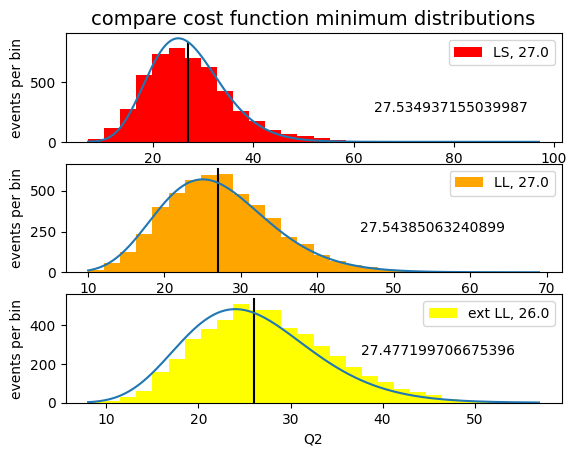

In [5]:
from scipy.stats import chi2

def plot_histo (ax, sample, ndof, label, color) :
    xMin = floor (min (sample))
    xMax = ceil (max (sample))
    N_bins = sturges (len (sample))
    bin_edges = np.linspace (xMin, xMax, N_bins)
    ax.set_xlabel ('Q2')
    ax.set_ylabel ('events per bin')
    ax.hist (sample,
             bins = bin_edges,
             color = color,
             label = label + ', ' + str (ndof),
            )
    vertical_limits = ax.get_ylim ()
    ax.plot ([ndof, ndof], vertical_limits, color = 'black')
    ax.legend ()

    x = np.arange (xMin, xMax, 0.001)
    bin_width = (xMax - xMin) / N_bins
    ax.plot (x, bin_width * len (sample) * chi2.pdf (x, df=ndof))
    ax.text (0.66 * xMax, len (sample) / 20., str (sum (sample) / len (sample)))
    
    
    
fig, axes = plt.subplots (nrows = 3, ncols = 1)
axes[0].set_title ('compare cost function minimum distributions', size=14)

plot_histo (axes[0], Q2_bin_LS, N_dof_LS, 'LS', 'red')
plot_histo (axes[1], Q2_bin_LL, N_dof_LL, 'LL', 'orange')
plot_histo (axes[2], Q2_bin_ext_LL, N_dof_ext_LL, 'ext LL', 'yellow')


